# Chapter10. 使用回归分析预测连续型目标变量
- 数据集的探索与可视化
- 实现线性回归模型的不同方法
- 训练可处理异常值的回归模型
- 回归模型的评估及常见问题
- 基于非线性数据拟合回归模型

## 1. 简单线性回归模型初探
$${\boldsymbol y} = {\boldsymbol w}^T{\boldsymbol x}$$

## 2. 波士顿房屋数据集
1978年收集的波士顿郊区房屋的信息。特征如下：
<pre>
1. CRIM      房屋所在镇的犯罪率
2. ZN        用地面积远大于25000平方英尺的住宅所占比例
3. INDUS     房屋所在镇无零售业务区域所占比例
4. CHAS      与查尔斯河有关的虚拟变量（房屋位于河边为1，否则为0）
5. NOX       一氧化氮浓度（千万分之一）
6. RM        每处寓所的平均房间数
7. AGE       业主自主房屋中，建于1940年之前的房屋所占的比例
8. DIS       房屋距离波士顿五大就业中心的加权距离
9. RAD       距离房屋最近的公路入口编号
10. TAX      每一万美元全额财产税金额
11. PTRATIO  房屋所在镇的师生比
12. B        1000(Bk - 0.63)^2 Bk为房屋所在镇非裔美籍人口比例
13. LSTAT    弱势群体人口所占的比例
14. MEDV     业主自主房屋的平均价格（1000美元）
</pre>

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


我们在后续将使用房屋价格（MEDV）作为预测变量，其他13个特征为解释变量进行预测。

### 可视化数据集的重要特征
探索性数据分析。借助EDA图形工具，直观地发现数据中的异常情况、分布情况、以及特征之间的关系。

首先借助散点图句很，可以汇总显示不同特征之间的两两关系：

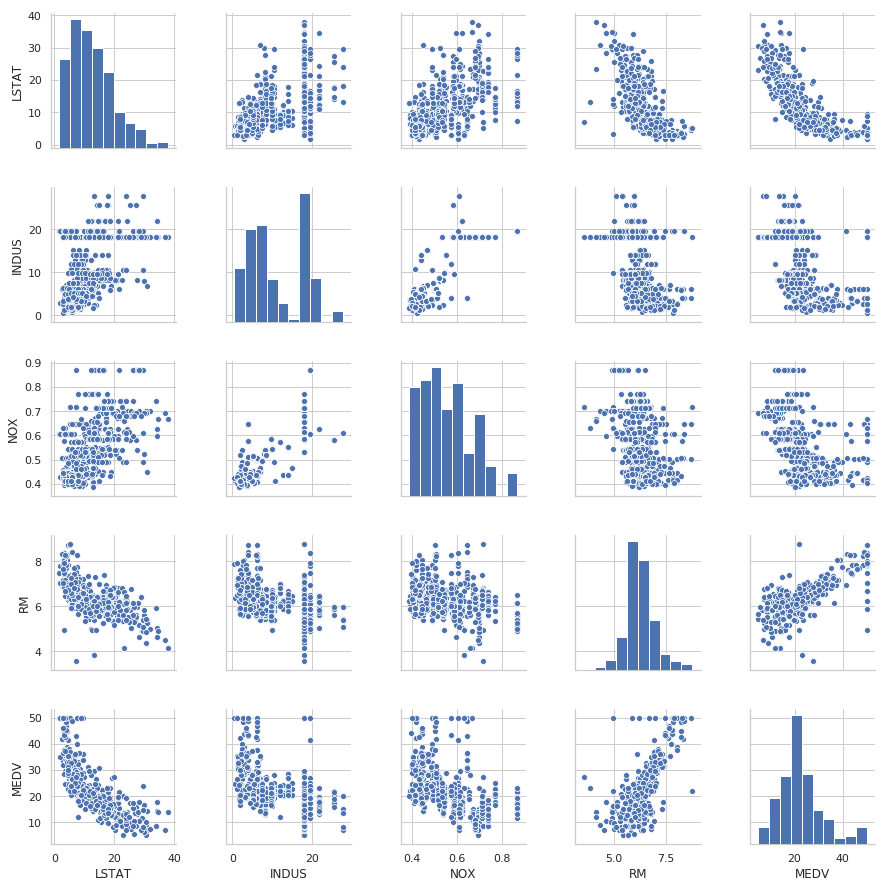

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', "MEDV"]

sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

通过散点图，我们可以看到房屋价格MEDV和平均房间数以及弱势人口所占比例LSTAT可能存在线性关系。同时，从各个变量的分布图（对角线部分）可以看到，MEDV呈现出正态分布，但是有异常值。

为了量化特征之间的关系，我们创建一个相关系数矩阵。相关系数矩阵是一个包含皮尔逊积距相关系数（Pearson product-moment correlation coefficient，Pearson's r）的方阵。相关系数的取值范围为-1到1。

$$r = \frac{\sum_{i=1}^n\left[\left(x^{(i)}-\mu_x\right)\left(y^{(i)}-\mu_y\right)\right]}
           {\sqrt{\sum_{i=1}^n{\left(x^{(i)}-\mu_x\right)}^2}\sqrt{\sum_{i=1}^n{\left(y^{(i)}-\mu_y\right)}^2}}=\frac{\sigma_{xy}}{\sigma_x\sigma_y}$$

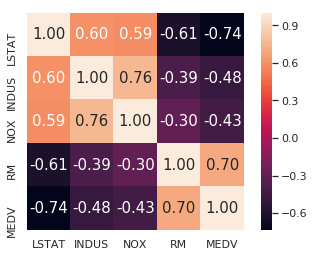

In [14]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm,
                 cbar=True,
                 # 在方格中显示数字
                 annot=True,
                 # 是否为方形
                 square=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.show()

In [22]:
sns.reset_orig()

/home/tuser/Software/Anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/tuser/Software/Anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## 3. 基于最小二乘法（OLS）构建线性回归模型

### a. 通过梯度下降计算回归参数
代价函数：
$$J(w) = \frac1{2}\sum_{i=1}^n{\left(y^{(i)} - {\hat y}^{(i)}\right)}^2$$

In [23]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [24]:
X = df[['RM']].values
y = df['MEDV'].values

In [25]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [26]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

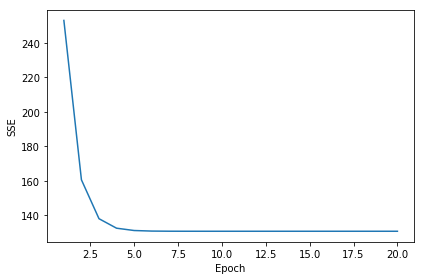

In [27]:
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

可以看到经过5次迭代后GD算法就收敛了。接下来绘制样本散点图：

In [28]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, color='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)
    return

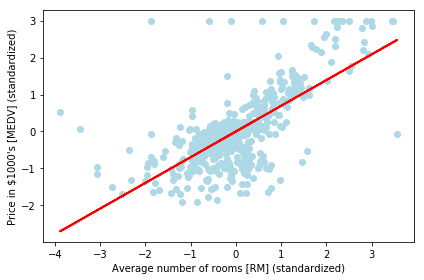

In [29]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
plt.show()

从图中可以看出房价和房间数呈正相关，但是也同样可以看出房间数在很多情况下并不能很好的解释房价。

In [30]:
# 斜率和截距
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


由于经过标准化处理，截距始终为0.

In [31]:
# 根据房间个数预测房屋价格
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


### b. 使用sklearn估计回归模型的系数

In [32]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


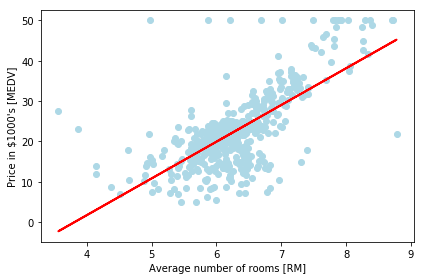

In [33]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
plt.show()

In [34]:
# 正规方程方法
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


## 4. 使用RANSAC拟合高鲁棒性回归模型